In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')

train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


### Analyze

In [ ]:
df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

In [3]:
train_df['Month'].value_counts()

c-8     8830
c-7     8706
c-3     8595
c-5     8543
c-6     8414
c-4     8408
c-10    8405
c-12    8265
c-11    8178
c-9     8163
c-1     8075
c-2     7418
Name: Month, dtype: int64

In [4]:
train_df['DayofMonth'].value_counts()

c-1     3399
c-20    3380
c-6     3377
c-22    3374
c-14    3366
c-17    3347
c-10    3342
c-27    3330
c-5     3321
c-28    3321
c-23    3314
c-25    3314
c-21    3312
c-19    3305
c-15    3297
c-2     3285
c-9     3283
c-7     3272
c-8     3258
c-4     3249
c-18    3246
c-26    3241
c-16    3240
c-13    3238
c-3     3228
c-12    3212
c-24    3210
c-11    3168
c-30    2976
c-29    2837
c-31    1958
Name: DayofMonth, dtype: int64

In [6]:
train_df['DayOfWeek'].value_counts()

c-4    14736
c-5    14657
c-2    14604
c-1    14569
c-3    14508
c-7    14097
c-6    12829
Name: DayOfWeek, dtype: int64

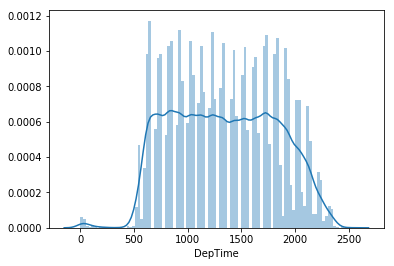

In [12]:
sns.distplot(train_df['DepTime'], bins=100);

In [15]:
train_df['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

In [18]:
train_df['Origin'].value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
DEN    2973
PHX    2729
LAS    2513
CVG    2346
EWR    2196
SLC    2103
DTW    1863
MSP    1856
SFO    1839
LGA    1737
BOS    1731
MCO    1708
PHL    1617
CLT    1611
SEA    1526
IAD    1516
BWI    1497
JFK    1496
MDW    1366
DCA    1354
SAN    1338
CLE    1241
TPA    1122
OAK    1025
FLL     999
       ... 
EYW       9
STX       8
LWS       8
ISO       8
WRG       8
ACY       8
HKY       7
HVN       7
APF       7
BRW       7
TUP       6
BPT       6
DLG       5
ACK       5
ADQ       5
PSE       4
LWB       4
SCC       4
PIE       3
BLI       3
OAJ       2
RFD       2
AKN       2
TEX       2
VIS       1
WYS       1
ADK       1
GST       1
VCT       1
ILG       1
Name: Origin, Length: 289, dtype: int64

In [19]:
train_df['Dest'].value_counts()

ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
DEN    2866
PHX    2749
LAS    2475
CVG    2434
EWR    2190
SLC    2170
DTW    1898
MSP    1822
SFO    1808
BOS    1803
LGA    1741
MCO    1728
CLT    1604
PHL    1600
IAD    1577
SEA    1520
JFK    1467
BWI    1461
DCA    1358
MDW    1295
SAN    1229
CLE    1218
TPA    1121
OAK    1030
SJC     960
       ... 
HVN      10
MQT      10
BPT       9
FLG       9
ISO       9
SPI       9
CDV       8
BET       8
SCC       8
VIS       7
ADQ       7
CDC       7
RFD       6
BGM       5
HKY       5
PSE       5
PIE       5
WYS       4
BRW       3
BLI       3
AKN       3
GST       2
ILG       2
DLG       2
SOP       2
VCT       1
TTN       1
TEX       1
ACK       1
LWB       1
Name: Dest, Length: 289, dtype: int64

In [20]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')

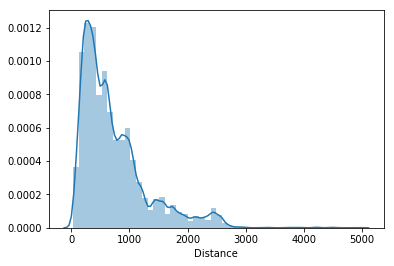

In [22]:
sns.distplot(train_df['Distance']);

In [24]:
train_df['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

### Preproc

In [17]:
from sklearn.preprocessing import LabelEncoder

In [111]:
# train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
# test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

In [112]:
le_carrier = LabelEncoder()
le_or_dest = LabelEncoder()
le_target = LabelEncoder()

In [113]:
unique_carrier = list(set(train_df['UniqueCarrier']) & set(train_df['UniqueCarrier']))
or_dest = list(set(train_df['Origin']) & set(train_df['Origin']) & set(train_df['Dest']) & set(train_df['Dest']))

train_df.loc[~train_df['Origin'].isin(or_dest), 'Origin'] = 'ATL'
train_df.loc[~train_df['Dest'].isin(or_dest), 'Dest'] = 'ATL'
train_df.loc[~train_df['UniqueCarrier'].isin(unique_carrier), 'UniqueCarrier'] = 'WN'

test_df.loc[~test_df['Origin'].isin(or_dest), 'Origin'] = 'ATL'
test_df.loc[~test_df['Dest'].isin(or_dest), 'Dest'] = 'ATL'
test_df.loc[~test_df['UniqueCarrier'].isin(unique_carrier), 'UniqueCarrier'] = 'WN'

In [114]:
def preproc(df, test=False):
    df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
    df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
    df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))
    
    if not test:
        le_carrier.fit(df['UniqueCarrier'])
        le_or_dest.fit(pd.concat([df['Origin'], df['Dest']]))
        del df['dep_delayed_15min']
    
    df['UniqueCarrier'] = le_carrier.transform(df['UniqueCarrier'])
    df['Origin'] = le_or_dest.transform(df['Origin'])
    df['Dest'] = le_or_dest.transform(df['Dest'])
    
    return df

In [115]:
y = le_target.fit_transform(train_df['dep_delayed_15min'])
X = preproc(train_df)

X_test = preproc(test_df, test=True)

X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,8,21,7,1934,0,17,78,732
1,4,20,3,1548,18,215,171,834
2,9,2,5,1422,20,226,59,416
3,11,25,6,1015,15,77,175,872
4,10,7,6,1828,19,173,199,423


### CV

In [43]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import xgboost as xgb

In [44]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=38)

In [116]:
params = {
    'n_estimators': [50, 100, 250, 500],
    'max_depth': [3, 5, 7, 9, 11]
}

regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=7, n_estimators=250)

gscv = GridSearchCV(regr, params, cv=skf, scoring='roc_auc')

gscv.fit(X, y)

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [117]:
gscv.best_score_

0.7488953150242457

# Train

In [118]:
import warnings

In [119]:
regr = xgb.XGBRegressor(random_state=42, n_jobs=-1, max_depth=7, n_estimators=250)
regr.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [120]:
ctb_test_pred = regr.predict(X_test)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv(PATH_TO_DATA / 'ctb_pred.csv')